<a href="https://colab.research.google.com/github/fodothing/ImprovedWord2Vec/blob/main/ImporvedWord2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prerequisities

In [1]:
# Import Libraries
import os
import re
import dgl
import nltk
import time
import math
import pickle
import random
import word2vec
import collections
import numpy as np
import torch as th
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from gensim.models import FastText
from gensim.models import Word2Vec
from torch.nn import functional as F
from sklearn.model_selection import train_test_split  # for train and dev set split


'''
nltk.download('punkt')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
'''
from dgl.nn import GATConv
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize




# Set Random Seed
SEED = 42
th.manual_seed(SEED)
th.cuda.manual_seed(SEED)
random.seed(SEED)

# Set Common Path
COMMON_PATH = "/Users/hshuaifile"

D:\ProgramData\Anaconda3\envs\hshuai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\ProgramData\Anaconda3\envs\hshuai\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#Prepare data

In [2]:
# Remove stop words and limite the max length in sentence sample.
def PrepareData(num_article, max_length=300):
  sentences = []
  Cleaned_ECN3K_PATH = f"{COMMON_PATH}/Word2Vec/data/NovelsOrganized3K"
  all_file = os.listdir(Cleaned_ECN3K_PATH)
  for i in range(len(all_file)):
    with open(f"{Cleaned_ECN3K_PATH}/{all_file[i]}", "r") as f:
      data = f.read()
    temp = re.split(r"[.!?]", data)
    if len(temp) > max_length: temp = temp[:max_length]
    if len(temp) == 0: continue

    sentences.extend(temp)
    if i==num_article:
      break

  str_sent = " ".join(sentences)
  word_list = re.split(r" ", str_sent.strip())
  word_list = [w for w in word_list if len(w)>0]
  vocab = list(set(word_list))
  vocab_size = len(vocab)
  idx2word = {i:w for i, w in enumerate(vocab)}
  word2idx = {w:i for i, w in enumerate(vocab)}

  print(f"All Articles: {num_article}")
  print(f"All Sentences: {len(sentences)}")
  print(f"All Words:{len(word_list)}")
  print(f"Vocab Size: {vocab_size}")
  
  return sentences, vocab, vocab_size, word_list, idx2word, word2idx  # sentences=["you are right", "yes, i am right", ...]

def Token(text, word2idx):
  temp = re.split(r" ", text.strip())
  return [word2idx[t] for t in temp if len(t)>0]  # [17, 66, 888, 182, ...]

def Batch(sentences, vocab, vocab_size, word_list, word2idx, nega_sample_size=5, batch_size=2):
  word_list = [word2idx[w] for w in word_list]
  '''
  word_counts = collections.Counter(word_list)
  total_words = sum(word_counts.values())
  word_freq = {word:count/total_words for word, count in word_counts.items()}
  words = list(word_freq.keys())
  freqs = list(word_freq.values())
  new_p = np.power(freqs, 0.75)
  new_p /= np.sum(new_p)
  ''' 

  all_token = [Token(sen, word2idx) for sen in sentences]  # [[1,2,3], [4,5,6], ...]
  vocab_id = [i for i in range(len(vocab))]
  # Create new word pair
  all_target_word = []
  all_rcontext_word = []  # Next word predict (right)
  all_negative_word = []

  for temp in all_token:
    if len(temp)>=4:
      for i, w in enumerate(temp):
        if i != 0 and i%2==0:
          tw = [t for t in temp[:i]]
          all_target_word.append(tw)
          all_rcontext_word.append(temp[len(tw)])
    else:
      continue

  train_number = len(all_target_word)

  for i in range(train_number):
    neg_samples = []
    while len(neg_samples) < nega_sample_size:
      sample = random.randint(0, vocab_size-1)
      if sample != all_rcontext_word[i] and sample not in neg_samples:
        neg_samples.append(sample)

    all_negative_word.append(neg_samples)
  all_negative_word = np.array(all_negative_word)

  batched_target_word = []
  batched_rcontext_word = []
  batched_negative_word = []
  for i in range(0, train_number, batch_size):
    batched_target_word.append(all_target_word[i:i+batch_size])
    batched_rcontext_word.append(all_rcontext_word[i:i+batch_size])
    batched_negative_word.append(all_negative_word[i:i+batch_size])
  
  print(f"All Training Sample: {train_number}")
  print(f"All Batched Number: {len(batched_rcontext_word)}")

  return batched_target_word, batched_rcontext_word, batched_negative_word



#Model

In [3]:
class GATLayer(th.nn.Module):
  def __init__(self, in_dim, hidden_dim):
    super(GATLayer, self).__init__()
    self.feat_drop = 0.2
    self.attn_drop = 0.2
    self.gat_layer = GATConv(in_dim, hidden_dim, 2, self.feat_drop, self.attn_drop, activation=F.relu)

  def forward(self, g, inputs):
    inputs = self.gat_layer(g, inputs)
    h = inputs.mean(1)
    
    return h


class GraphCoarsing(th.nn.Module):
  def __init__(self, in_dim, hidden_dim, device):
    super(GraphCoarsing, self).__init__()
    self.gat = GATLayer(in_dim, hidden_dim)
    self.device = device
    self.gram = 1
  
  def AddEdges(self, n):  # For Pooling graph
    edges = []
    for i in range(n):
      for j in range(max(0, i-self.gram), min(i + self.gram + 1, n)):  # Directed graph
        edges.append([i, j])
    
    return edges

  def BuildGraph(self, node_hidden):
    n = len(node_hidden)
    u, v = zip(*self.AddEdges(n))
    g = dgl.graph((u, v), num_nodes=n).to(self.device)
    g.ndata['h'] =  node_hidden

    return g
  
  def forward(self, node_hidden):
    g = []
    for t in node_hidden:
      g.append(self.BuildGraph(t))
    batch_g = dgl.batch(g)
    batch_g.ndata['h'] = self.gat(batch_g, batch_g.ndata['h']) # Update node embedding
    
    return dgl.mean_nodes(batch_g, feat='h')


class SkipGramNegSampling(th.nn.Module):
  def __init__(self, vocab_size, emb_dim, device):
    super(SkipGramNegSampling, self).__init__()
    self.device = device
    self.emb_dim = emb_dim
    self.target_embedding = th.nn.Embedding(vocab_size, emb_dim)
    self.context_embedding = th.nn.Embedding(vocab_size, emb_dim)
    self.coarsening = GraphCoarsing(emb_dim, emb_dim, device)

  def forward(self, target_word, context_word, negative_words):
    target_emb = []
    for target in target_word:
      temp_target_emb = self.target_embedding(th.tensor(target).to(self.device))
      target_emb.append(temp_target_emb)
    target_new = self.coarsening(target_emb)

    context_emb = self.context_embedding(th.tensor(context_word).to(self.device))
    negative_emb = self.context_embedding(th.tensor(negative_words).to(self.device))


    # Calculate loss
    context_score = th.sum(th.mul(target_new, context_emb).squeeze(), dim=1)
    negative_score = th.bmm(negative_emb, target_new.unsqueeze(2)).squeeze()
    loss = th.mean(th.sum(F.logsigmoid(context_score))) + th.mean(th.sum(F.logsigmoid(-1*negative_score)))
    
    return -loss

#Run Experiment

##Train

In [6]:
def Train(model, epoch, target, rcontext, negative, emb_dim, num_article, device):
  optimizer = th.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
  #scheduler_lr = th.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda = lambda epoch:0.1 * epoch)
  all_loss = []

  for e in range(epoch):
    step = 0
    temp_loss = []
    for i in range(len(target)):
      step +=1
      optimizer.zero_grad()
      loss = model(target[i], rcontext[i], negative[i])
      loss.backward()
      optimizer.step()
      #scheduler_lr.step()

      if (step+1)%800==0:
        print(f"{e+1}/{epoch}, step={step+1}, loss={loss.item():.2f}")
      temp_loss.append(loss.item())
    all_loss.append(np.mean(temp_loss))

  
  now_time = datetime.now()
  t = re.sub(r' |:|\.', '-', str(now_time))
  df = pd.DataFrame({"loss":all_loss})
  df.to_csv(f"{COMMON_PATH}/Word2Vec/model/loss_acc/loss-{t}_{emb_dim}_{num_article}.csv", index=False)

  return model



##Run

In [8]:
# Set Training Device
DEVICE = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
if th.cuda.is_available():
  print(f'device: {DEVICE}')
  print(f'name: {th.cuda.get_device_name(0)}')
  print(f'='*50)

!rm /Users/hshuaifile/Word2Vec/model/loss_acc/*


def SaveEmbedding(model, emb_dim, num_article):
  dir_path = f"{COMMON_PATH}/Word2Vec/data/trainedembedding"
  filename = f"{dir_path}/myw2v_{emb_dim}_{num_article}.pth"
  embedding1 = model.target_embedding.weight.detach().cpu().numpy()
  embedding2 = model.context_embedding.weight.detach().cpu().numpy()
  embedding = (0.8*embedding1 + 0.2*embedding2)
  th.save(embedding, filename)
  print("Embedding Saved!")

def SaveWord2Idx(word2idx, emb_dim, num_article):
  dir_path = f"{COMMON_PATH}/Word2Vec/data/trainedembedding"
  with open(f"{dir_path}/myw2v_{emb_dim}_{num_article}.pickle", 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)


epoch = 2
emb_dim =300  # 300, 100,50
num_article = 100 # 100, 500, 1000, 3395

t0 = time.time()
print(f"emb_dim:{emb_dim}")
sentences, vocab, vocab_size, word_list, idx2word, word2idx = PrepareData(num_article)
target, rcontext, negative = Batch(sentences, vocab, vocab_size, word_list, word2idx, nega_sample_size=5, batch_size=64)
print(f"Prepare Data and Batch Using Time: {(time.time()-t0)/60:.2f}m")
print(f"="*50)

model = SkipGramNegSampling(vocab_size, emb_dim, DEVICE)
model.to(DEVICE)
new_model = Train(model, epoch, target, rcontext, negative, emb_dim, num_article, DEVICE)

SaveEmbedding(new_model, emb_dim, num_article)
SaveWord2Idx(word2idx, emb_dim, num_article)

print(f"All Time Using: {(time.time()-t0)/3600:.2f}h")
print("="*50)

device: cuda:0
name: NVIDIA GeForce RTX 3090
emb_dim:300
All Articles: 100
All Sentences: 16093
All Words:458886
Vocab Size: 22194
All Training Sample: 217277
All Batched Number: 3395
Prepare Data and Batch Using Time: 0.03m
1/2, step=800, loss=253.32
1/2, step=1600, loss=146.51
1/2, step=2400, loss=78.95
1/2, step=3200, loss=78.40
2/2, step=800, loss=86.24
2/2, step=1600, loss=63.30
2/2, step=2400, loss=66.38
2/2, step=3200, loss=72.09
Embedding Saved!
All Time Using: 0.11h


#Result Plot

##Loss Over Epoch

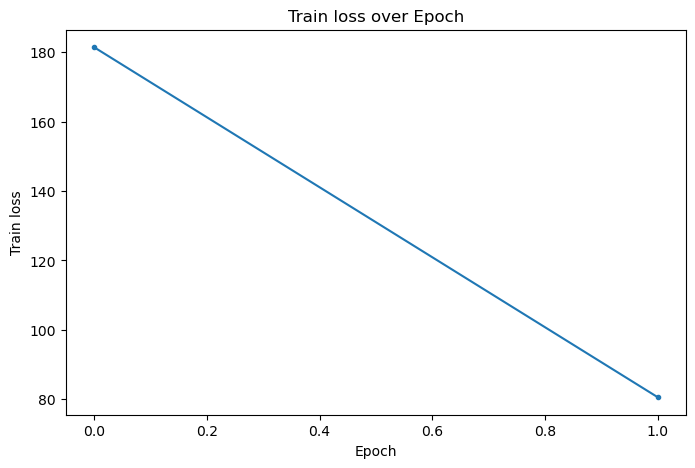

In [10]:
def ReadAllResult():
  all_loss = []
  all_file = os.listdir(f"{COMMON_PATH}/Word2Vec/model/loss_acc")
  df = pd.read_csv(f"{COMMON_PATH}/Word2Vec/model/loss_acc/{all_file[0]}")
  all_loss.append(df["loss"])
  
  return all_loss


all_loss = ReadAllResult()
#print(all_loss)
x = [i for i in range(len(all_loss[0]))]

fig = plt.figure(figsize=(8,5), dpi=100)
ax1 = fig.add_subplot(1, 1, 1)

plt.ylabel("Train loss")
plt.xlabel("Epoch")
plt.title("Train loss over Epoch")
ax1.plot(x, all_loss[0], '.-', label="loss")

#plt.savefig(f"{COMMON_PATH}/Word2Vec/model/fig/train_myw2v50d1000a_loss.pdf", bbox_inches="tight")
plt.show()

## Running Time

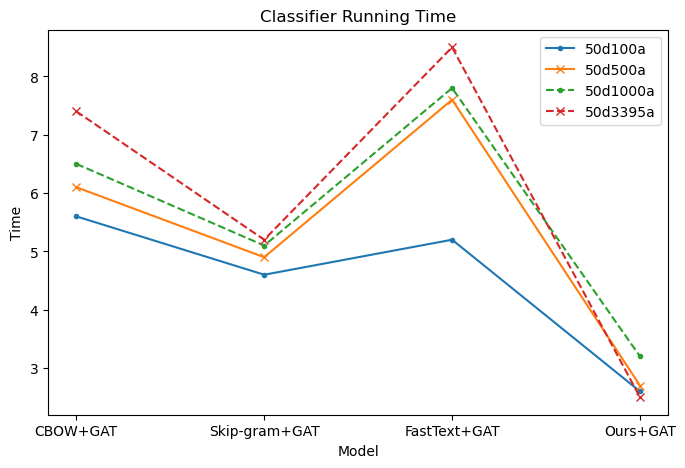

In [ ]:
x = ["CBOW+GAT", "Skip-gram+GAT", "FastText+GAT", "Ours+GAT"]
y_50d_100a = [5.6, 4.6, 5.2, 2.6]
y_50d_500a = [6.1, 4.9, 7.6, 2.7]
y_50d_1000a = [6.5, 5.1, 7.8, 3.2]
y_50d_3395a = [7.4, 5.2, 8.5, 2.5]


fig = plt.figure(figsize=(8,5), dpi=100)
ax1 = fig.add_subplot(1, 1, 1)

plt.ylabel("Time")
plt.xlabel("Model")
plt.title("Classifier Running Time")

ax1.plot(x, y_50d_100a, '.-', label="50d100a")
ax1.plot(x, y_50d_500a, '-x', label="50d500a")
ax1.plot(x, y_50d_1000a, '-<', label="50d1000a")
ax1.plot(x, y_50d_3395a, '->', label="50d3395a")

plt.legend()
#plt.savefig(f"{COMMON_PATH}/Word2Vec/model/fig/runningTime_50d1000a.pdf", bbox_inches="tight")
plt.show()

# Miscellaneous

##Check

In [9]:
def LoadEmbedding(filename):
  return th.load(filename)

def cos_similarity(vec1,vec2):
  dot_product = th.dot(vec1, vec2)
  norm1 = th.norm(vec1, 2)
  norm2 = th.norm(vec2, 2)
  similarity = dot_product / (norm1*norm2)

  return similarity

model1 = th.load(f"{COMMON_PATH}/Word2Vec/data/trainedembedding/myw2v_300_100.pth")
with open(f"{COMMON_PATH}/Word2Vec/data/trainedembedding/myw2v_300_100.pickle", 'rb') as handle:
  myword2idx = pickle.load(handle)

check_word = "pistol"

all_sim_value = []
all_sim_word = []
v1 = model1[myword2idx[check_word]]
print(v1)
for word in myword2idx.keys():
  if word!=check_word:
    v2 = model1[myword2idx[word]]
    all_sim_value.append(cos_similarity(th.tensor(v1),th.tensor(v2)))
    all_sim_word.append(word)

temp = zip(all_sim_value, all_sim_word)
b = sorted(temp,reverse=True)
print(b[:10])
  


[ 1.75507588e-03 -4.00858524e-04 -2.73402850e-03 -1.09849432e-04
  7.12525889e-06  6.64298454e-07 -1.08173583e-03 -7.50121486e-04
 -3.06829752e-05  6.53365787e-05 -4.37480077e-04 -7.98831970e-05
 -4.42048913e-04 -1.06922716e-05 -2.60260864e-03 -6.68246357e-05
 -7.56913389e-04 -9.52617629e-05  1.25839747e-03 -7.35981375e-05
 -1.09479566e-04  6.76109048e-04 -1.78446266e-04 -7.11067766e-03
 -4.27768187e-04 -7.69477410e-05 -1.43518928e-03 -1.29914290e-04
 -1.63319492e-05 -6.54114410e-03 -7.73331337e-03 -3.46743727e-05
 -1.39087287e-03  6.17985846e-04 -7.13147310e-05  5.20359434e-04
 -3.76107782e-04 -3.92031297e-03 -1.60147247e-04 -3.03678699e-02
  6.65469386e-04  3.20384133e-04 -2.67524938e-05  7.81213050e-04
 -1.06502569e-06 -1.90313219e-03 -2.55347434e-02  2.87685520e-03
  3.82936007e-04  5.10925148e-03 -3.69463851e-05 -1.31557288e-04
 -7.85508091e-05 -1.87582642e-04 -6.03810440e-05 -3.04377143e-04
 -1.21168967e-03 -4.76396410e-03 -1.06968721e-04 -2.88173615e-04
 -2.67705764e-04 -7.09635

##Debug

In [ ]:
loss = [0.1,0.2]
avg = np.mean(loss)
type(avg)



numpy.float64